In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

from datetime import datetime, timedelta
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Importa los datos de valencia y activación
val_act = pd.read_csv('Data/val_act.csv')    
val_act['start'] = pd.to_datetime(val_act['start'], format='%Y-%m-%d %H:%M:%S')
val_act['end'] = pd.to_datetime(val_act['end'], format='%Y-%m-%d %H:%M:%S')

## Procesado Datos Fitbit

En esta sección se dividen los datos tomados de la fitbit por participante. A cada serie temporal se le aplica un suavizado, un estandarizado y una interpolación. Al final se extraen distintos estadísticos de la subserie temporal correspondiente a cada clip de cada participante.

In [3]:
# Función que dadas las pulsaciones de un usuario hace una interpolación
def createInterpolation(df, _id):
    x = df['segundos'].tolist()
    y = df['value'].tolist()
    tck = interpolate.splrep(x, y, s=0)
    return tck

In [4]:
import math

# Calcula el root mean square de los elementos de un array
def rms(array):
    # Eleva los elementos al cuadrado
    array = [x*x for x in array]
    # Los suma
    value = sum(array)
    # Divide entre el total de elementos
    value = value/len(array)
    # Hace la raíz cuadrada
    value = math.sqrt(value)
    return value    

In [5]:
# Función que devuelve True si hay suficientes datos en una fila
def enoughData(clip_start, clip_end, puls_exp, min_data):
    puls_clip = puls_exp.copy()
    puls_clip = puls_clip[puls_clip['segundos']>clip_start]
    puls_clip = puls_clip[puls_clip['segundos']<clip_end]
    return len(puls_clip) > min_data

In [6]:
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import argrelextrema

def principalesArmonicos(x0, y0, T):
    N = len(x0)
    xf = fftfreq(N, T)[:N//2]
    yf = 2.0/N * np.abs(fft(y0)[0:N//2])
    # Obtiene los indices de los máximos relativos
    lista_indices = argrelextrema(yf, np.greater)
    lista_indices = lista_indices[0].tolist()
    
    if yf[0]>yf[1]:
        lista_indices.append(0)
    
    # Obtiene las amplitudes de cada índice
    ind_val = { i:yf[i] for i in lista_indices}
    # Coge los índices de las 5 mayores amplitudes
    ind_val = sorted(ind_val.items(), key=lambda x:x[1],reverse=True)[:1]
    # Saca las frecuencias de las 5 mayores amplitudes
    freq = [xf[i[0]] for i in ind_val]
    
    return freq

In [7]:
# Función que calcula distintas métricas para cada clip si hay suficientes datos
def metricsCalculator(row, puls_exp, min_data, tck,_id):
    clip_start = row.loc['seg_start']
    clip_end = row.loc['seg_end']
    
    if enoughData(clip_start, clip_end, puls_exp, min_data):
        T = 5 # sample rate
        xfit = np.arange(clip_start, clip_end, T)
        
        # Los valores fuera del intervalo los pone a 0
        yfit = interpolate.splev(xfit, tck, der=0,ext=1)
        # Eliminamos los 0
        yfit = [i for i in yfit if i!=0]
        
        row.loc['x'] = xfit
        row.loc['y'] = yfit
        row.loc['min'] = min(yfit)
        row.loc['max'] = max(yfit)
        row.loc['mean'] = statistics.mean(yfit)
        row.loc['median'] = statistics.median(yfit)
        row.loc['stdev'] = statistics.stdev(yfit)
        row.loc['skew'] = stats.skew(yfit)
        row.loc['kurtosis'] = stats.kurtosis(yfit)
        row.loc['rms'] = rms(yfit)
        autocorelation_parameters = sm.tsa.acf(yfit, nlags=5)
        row.loc['autocorr1'] = autocorelation_parameters[1]
        row.loc['autocorr2'] = autocorelation_parameters[2]
        row.loc['autocorr3'] = autocorelation_parameters[3]
        row.loc['autocorr4'] = autocorelation_parameters[4]
        row.loc['autocorr5'] = autocorelation_parameters[5]
        freq = principalesArmonicos(xfit, yfit, T)
        row.loc['freq1'] = freq[0]
        
    return row

In [8]:
import statistics
from scipy import interpolate

def readyData(min_data, smoothing, val_act):
    # Importa los datos de la Fitbit
    pulsaciones = pd.read_csv('Data/pulsaciones.csv')
    
    # Aplica el suavizado con medias móviles
    pulsaciones['value'] = pulsaciones['value'].rolling(smoothing).mean()
    
    
    pulsaciones['datetime'] = pd.to_datetime(pulsaciones['datetime'], format='%Y-%m-%d %H:%M:%S')    
    list_ids = val_act['id'].unique()
    df_total = pd.DataFrame()
    for _id in list_ids:
    
        dfexp = val_act[val_act['id']==_id].copy()
    
        # -------------Define los segundos desde el inicio del experimento----------------
        # Se define el principio y el final del experimento
        start = dfexp[dfexp['clip']=='relaja1']['start'].values[0]
        end = dfexp[dfexp['clip']=='relaja2']['end'].values[0]

        # Se añade una columna que cuente los segundos desde el inicio del experimento
        dfexp['seg_start'] = (dfexp['start'] - dfexp['start'].min()) // pd.Timedelta('1s')
        dfexp['seg_end'] = (dfexp['end'] - dfexp['start'].min()) // pd.Timedelta('1s')
    
    
        # -------------Define las pulsaciones de este experimento--------------
        # Limita los datos fitbit a 1 solo experimento
        puls_exp = pulsaciones.copy()
        puls_exp = puls_exp[puls_exp['datetime']>start]
        puls_exp = puls_exp[puls_exp['datetime']<end]

        # Saca una columna con los segundos
        puls_exp['segundos'] = (puls_exp['datetime'] - puls_exp['datetime'].min()) // pd.Timedelta('1s')
    
        # -------------Estandarización--------------------------
        # Coge los segundos donde empiezan y acaban las relajaciones
        start_rel1 = dfexp[dfexp['clip']=='relaja1']['seg_start'].values[0]
        end_rel1 = dfexp[dfexp['clip']=='relaja1']['seg_end'].values[0]
        start_rel2 = dfexp[dfexp['clip']=='relaja2']['seg_start'].values[0]
        end_rel2 = dfexp[dfexp['clip']=='relaja2']['seg_end'].values[0]

        # Se cogen solo las pulsaciones de las líneas base
        values1 = puls_exp[(puls_exp['segundos'] >= start_rel1) & (puls_exp['segundos'] <= end_rel1)]
        values2 = puls_exp[(puls_exp['segundos'] >= start_rel2) & (puls_exp['segundos'] <= end_rel2)]
        values = values1['value'].tolist() + values2['value'].tolist()

        mu = statistics.mean(values)
        sigma = statistics.stdev(values)
        puls_exp['value'] = (puls_exp['value'] - mu)/sigma
    
        # -------------Interpolación--------------------------
        # Dibuja y obtiene los puntos de la interpolación
        tck = createInterpolation(puls_exp, _id)
    
        # Quita las filas correpondientes a las relajaciones
        dfexp.dropna(axis=0,inplace=True)
    
        # Se añaden las métricas al dataframe 
        dfexp = dfexp.apply(metricsCalculator, 
                            axis=1,puls_exp=puls_exp,
                            min_data=min_data, tck=tck, _id=_id)
    
        # Lo concatena al dataframe con todos los usuarios
        df_total = pd.concat([df_total, dfexp])

    # Quita las filas sin suficientes datos
    df_total.dropna(inplace=True)    
    df_total.reset_index(drop=True,inplace=True)
    
    # Escalado de variables
    X = df_total.drop(['start', 'duracion', 'clip', 'end', 'id',
       'seg_start', 'seg_end','x','y','activacion','valencia'], axis = 1)
    
    scaler = MinMaxScaler()
 
    X = pd.DataFrame(scaler.fit_transform(X),
            columns=X.columns, index=X.index)  
    
        
    return (df_total, X)

# Regresión lineal

In [9]:
def linearRegression(X,y):
    X2 = sm.add_constant(X,prepend=True, has_constant='skip')
    est = sm.OLS(y, X2)
    est2 = est.fit()    
    return est2

## Análisis parámetros para la Regresión lineal

In [10]:
def tryThisRegression(min_data, smoothing, val_act):
    # Prepara el dataframe
    df_total, X = readyData(min_data, smoothing, val_act)

    y_act = df_total['activacion']
    y_val = df_total['valencia']
    
    length = len(df_total)
    
    # Calcula las regresiones
    est2_act = linearRegression(X,y_act)
    est2_val = linearRegression(X,y_val)
    
    # Obtiene los p-valores
    p_act = est2_act.f_pvalue
    p_val = est2_val.f_pvalue
    
    # Obtiene los r2 t los r2 ajustados
    r_act = est2_act.rsquared
    r_val = est2_val.rsquared
    radj_act = est2_act.rsquared_adj
    radj_val = est2_val.rsquared_adj
    
    return pd.DataFrame({'Min Data': [min_data], 'Smoothing':[smoothing],
                  'P-Value Act':[p_act],'R-Squared Act':[r_act], 'Radj-Squared Act':[radj_act],
                  'P-Value Val':[p_val],'R-Squared Val':[r_val], 'Radj-Squared Val':[radj_val], 
                         'Size':[length]})

In [11]:
import itertools

min_data_list = [5,10,15,20,25,30,35]
smoothing = range(1,16)


thelist = [min_data_list,smoothing]

result = pd.DataFrame()

for element in tqdm(itertools.product(*thelist)):
    min_data = element[0]
    smoothing = element[1]
    result = pd.concat([result, 
                        tryThisRegression(min_data,smoothing, val_act)])


90it [02:47,  1.31s/it]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
91it [02:48,  1.27s/it]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
92it [02:49,  1.15s/it]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linea

In [12]:
result.to_csv('Data/pvalues.csv',index=False)

### Analizando el efecto de los parámetros

In [13]:
result = pd.read_csv('Data/pvalues.csv')
result.dropna(inplace=True)
result = result.rename(columns={"P-Value Act": "P-Valor Arousal","P-Value Val": "P-Valor Valencia",
                               "Min Data": "Medidas Mínimas", "Smoothing": "Factor Suavizado"})
result.sort_values(by='P-Valor Valencia', ascending=True)

,Medidas Mínimas,Factor Suavizado,P-Valor Arousal,R-Squared Act,Radj-Squared Act,P-Valor Valencia,R-Squared Val,Radj-Squared Val,Size
39,15,10,0.459664,0.169217,0.000652,0.007707,0.330504,0.194664,84
54,20,10,0.518711,0.185687,-0.010872,0.011425,0.363079,0.209339,73
72,25,13,0.084819,0.422599,0.184845,0.024969,0.484107,0.271681,49
53,20,9,0.122579,0.272216,0.096544,0.035789,0.323401,0.160084,73
13,5,14,0.239544,0.123956,0.025840,0.046569,0.167211,0.073939,140
...,...,...,...,...,...,...,...,...,...
15,10,1,0.870249,0.084261,-0.059787,0.867938,0.084654,-0.059333,104
20,10,6,0.432570,0.139346,0.003962,0.878916,0.082755,-0.061531,104
30,15,1,0.962523,0.078898,-0.107993,0.882756,0.102871,-0.079155,84
61,25,2,0.568108,0.270013,-0.030570,0.900807,0.177817,-0.160728,49


In [14]:
def plotMetrics(df, yvariable, xvariable):
    df_analysis = df[[xvariable,yvariable]]
    
    x = df_analysis.groupby(xvariable).max().index.tolist()
    maxs = df_analysis.groupby(xvariable).max()[yvariable].tolist()
    quantil3 = df_analysis.groupby(xvariable).quantile(.75)[yvariable].tolist()
    medians = df_analysis.groupby(xvariable).median()[yvariable].tolist()
    quantil1 = df_analysis.groupby(xvariable).quantile(.25)[yvariable].tolist()
    mins = df_analysis.groupby(xvariable).min()[yvariable].tolist()
    
    fig = plt.figure(figsize = (8, 6))
    line_chart1 = plt.plot(x, maxs,':')
    line_chart2 = plt.plot(x, quantil3,'--')
    line_chart3 = plt.plot(x, medians)
    line_chart4 = plt.plot(x, quantil1,'--')
    line_chart5 = plt.plot(x, mins,':')
    plt.xlabel(xvariable,fontsize = 18)
    plt.ylabel(yvariable,fontsize = 18)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    plt.legend(['Max','3ºCuartil', 'Mediana', '1ºCuartil', 'Min'], loc=1)
    plt.show()

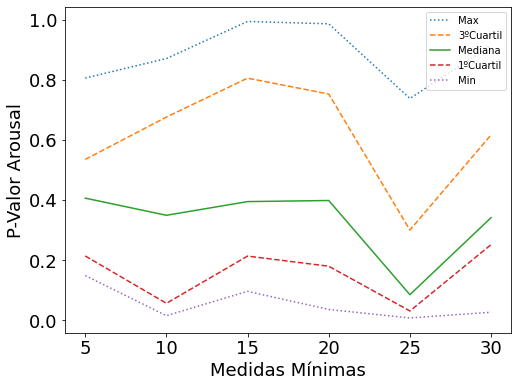

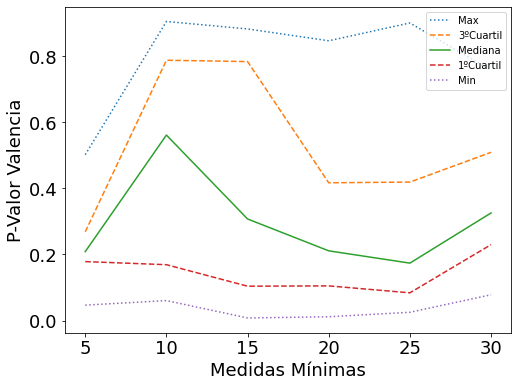

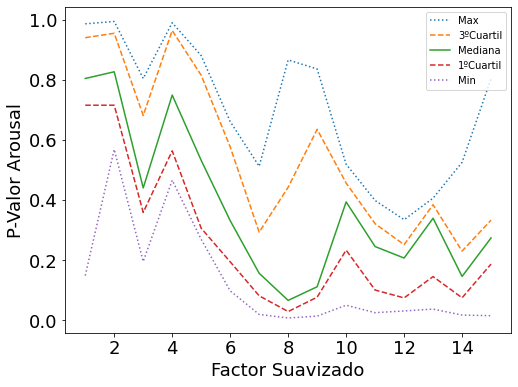

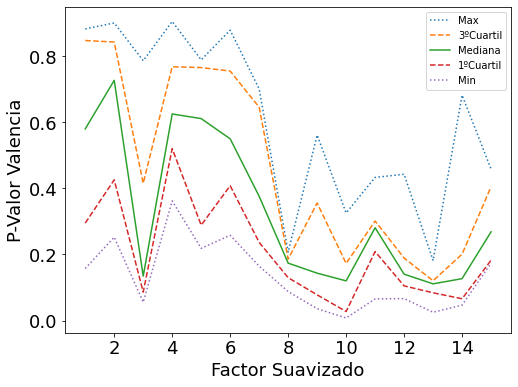

In [15]:
for x in ['Medidas Mínimas','Factor Suavizado']:
    for y in ['P-Valor Arousal','P-Valor Valencia']:
        plotMetrics(result, y, x) 

## Stepwise Forward Selection

In [16]:
def stepwiseForwardSelection(X, y):
    added_variables = []
    waiting_variables = X.columns.tolist()
    best_pvalue = 1
    results = pd.DataFrame()
    while len(waiting_variables) > 0:
        best_score = -2
        for variable in waiting_variables:
            variables = added_variables + [variable]
            X0 = X[variables]
            est2 = linearRegression(X0,y)
            score = est2.rsquared_adj
            if score > best_score:
                best_score = score
                best_variable = variable
                best_pvalue = est2.f_pvalue
            
        added_variables.append(best_variable)
        waiting_variables.remove(best_variable)
        results = pd.concat(objs=[results, pd.DataFrame.from_dict({'variables': [best_variable],
                                                                   'R-Adj':[best_score],
                                                                  'P-Value': [best_pvalue]})],axis=0)
    return results

### Activación

In [17]:
min_data = 25
smoothing = 8
df_total_act, X_act = readyData(min_data, smoothing, val_act)
y_act = df_total_act['activacion']

stepwiseForwardSelection(X_act, y_act)

,variables,R-Adj,P-Value
0,autocorr1,0.224544,0.000345
0,autocorr2,0.299669,0.000104
0,autocorr5,0.362399,0.000033
0,freq1,0.387190,0.000033
0,autocorr3,0.398382,0.000047
0,skew,0.402353,0.000078
0,autocorr4,0.401172,0.000142
0,stdev,0.397539,0.000262
0,rms,0.411639,0.000279
0,kurtosis,0.398155,0.000613


### Valencia

In [18]:
min_data = 25
smoothing = 13
df_total_val, X_val = readyData(min_data, smoothing,val_act)
y_val = df_total_val['valencia']

stepwiseForwardSelection(X_val, y_val)

,variables,R-Adj,P-Value
0,freq1,0.098520,0.016001
0,kurtosis,0.157209,0.007353
0,autocorr3,0.227767,0.002101
0,skew,0.268598,0.001249
0,median,0.275782,0.001748
0,mean,0.302504,0.001389
0,stdev,0.316824,0.001483
0,autocorr5,0.306807,0.002789
0,autocorr4,0.312292,0.003455
0,autocorr2,0.326523,0.003451


## Analizando los mejores modelos

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def showVif(X):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    return vif

### Activación

In [20]:
X2_act = X_act[['autocorr1', 'autocorr2', 'autocorr5', 
         'freq1', 'autocorr3', 'skew', 'autocorr4','stdev','rms']]
est2_act = linearRegression(X2_act,y_act)
print(est2_act.summary())

                            OLS Regression Results                            
Dep. Variable:             activacion   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     4.731
Date:                Wed, 19 Oct 2022   Prob (F-statistic):           0.000279
Time:                        12:57:31   Log-Likelihood:                -93.890
No. Observations:                  49   AIC:                             207.8
Df Residuals:                      39   BIC:                             226.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2596      2.870      1.833      0.0

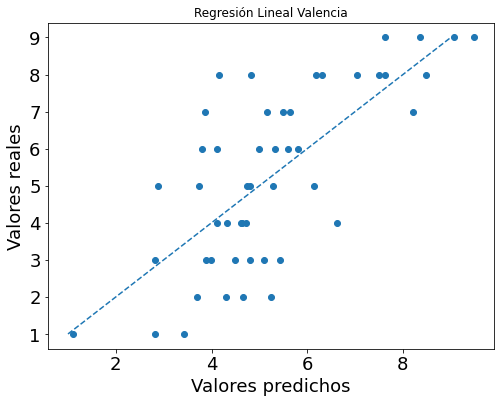

In [21]:
pred_act = est2_act.fittedvalues
fig = plt.figure(figsize = (8, 6))
plt.scatter(pred_act, y_act, alpha=1)
linea = range(1,10)
plt.plot(linea, linea,'--')
plt.title('Regresión Lineal Valencia')
plt.xlabel('Valores predichos',fontsize = 18)
plt.ylabel('Valores reales',fontsize = 18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

#### Residuos

(1.0, 9.6)

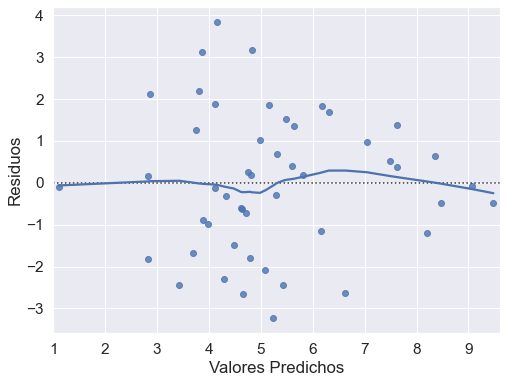

In [22]:
sn.set(rc={"figure.figsize":(8, 6)})
sn.set(font_scale=1.4)
fig, ax = plt.subplots()
sn.residplot(x=pred_act, y=y_act, lowess=True,ax=ax)
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
ax.set_xlim(1,9.6)

#### Colinearidad

In [23]:
showVif(X2_act)

,VIF Factor,features
0,2144.759679,autocorr1
1,13565.219832,autocorr2
2,1699.320517,autocorr5
3,1.962390,freq1
4,18321.182047,autocorr3
5,9.560551,skew
6,8944.214158,autocorr4
7,8.775419,stdev
8,6.552420,rms


<AxesSubplot:>

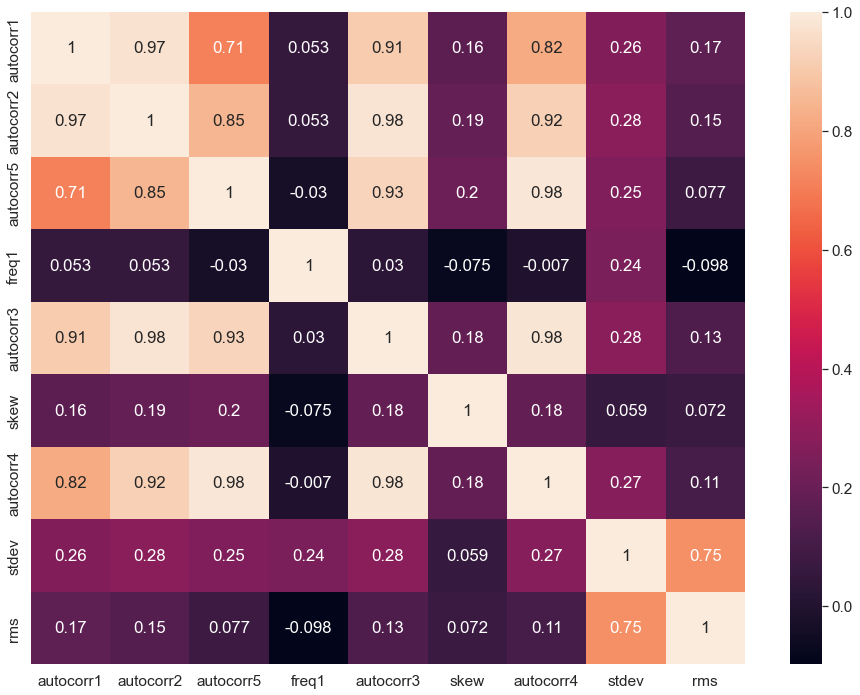

In [24]:
corr_matrix = X2_act.corr()
fig, ax = plt.subplots(figsize=(16, 12))
sn.heatmap(corr_matrix, annot=True)

### Valencia

In [25]:
X2_val = X_val[['freq1','kurtosis','autocorr3','skew','median','mean','stdev','autocorr5','autocorr4','autocorr2']]
est2_val = linearRegression(X2_val,y_val)
print(est2_val.summary())

                            OLS Regression Results                            
Dep. Variable:               valencia   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     3.327
Date:                Wed, 19 Oct 2022   Prob (F-statistic):            0.00345
Time:                        12:57:34   Log-Likelihood:                -92.744
No. Observations:                  49   AIC:                             207.5
Df Residuals:                      38   BIC:                             228.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.9378      8.387     -0.708      0.4

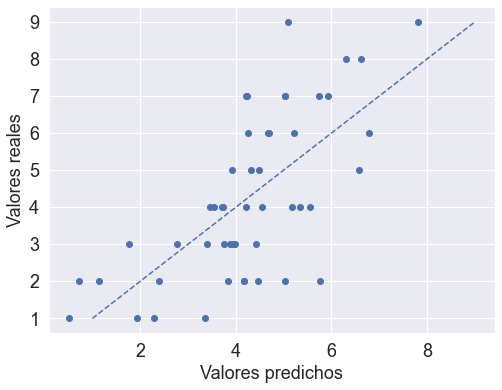

In [26]:
pred_val = est2_val.fittedvalues

fig = plt.figure(figsize = (8, 6))
plt.scatter(pred_val, y_val, alpha=1)
linea = range(1,10)
plt.plot(linea, linea,'--')
plt.xlabel('Valores predichos',fontsize = 18)
plt.ylabel('Valores reales',fontsize = 18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

#### Residuos

(0.4, 7.9)

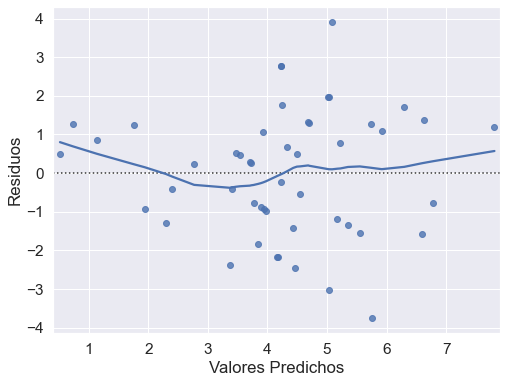

In [27]:
sn.set(rc={"figure.figsize":(8, 6)})
sn.set(font_scale=1.4)
fig, ax = plt.subplots()
sn.residplot(x=pred_val, y=y_val, lowess=True,ax=ax)
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
ax.set_xlim(0.4,7.9)

#### Colineareidad

In [28]:
showVif(X2_val).sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features
2,10481.944197,autocorr3
8,8200.135312,autocorr4
9,2078.186941,autocorr2
7,1894.413508,autocorr5
4,171.275363,median
5,161.534466,mean
3,22.124866,skew
1,4.655067,kurtosis
6,4.506752,stdev
0,2.023891,freq1


<AxesSubplot:>

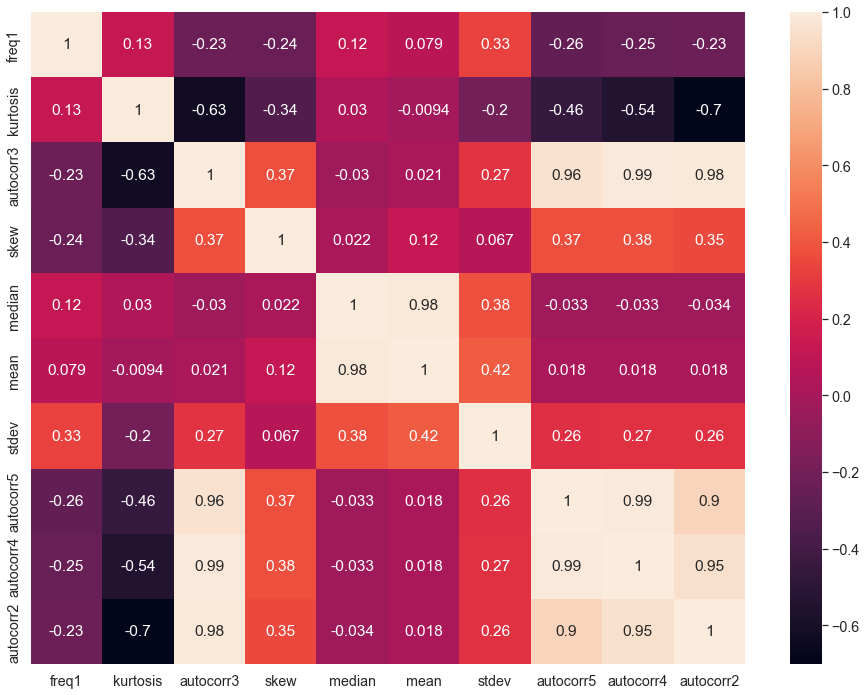

In [29]:
corr_matrix = X2_val.corr()
sn.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(16, 12))
sn.heatmap(corr_matrix, annot=True)

# Analizando diferencias entre residuos

Para ver si las observaciones de algunos clips o personas concretas se ajustan mejor a los modelos de regresión lineal se van a estudiar los valores absolutos de los residuos. Concretamente se va hacer la media de estos valores absolutos para cada clip/persona. Se va a evaluar si la diferencia entre las medias es significativa usando el test de Kruskal-Wallis.

In [30]:
def kruskalTest(df, grupo):
    
    # Agrupa los residuos y saca una lista
    lista_residuos = df.groupby(grupo)['residuos'].apply(list).tolist()
    
    # Test Kruskal-Wallis
    stat, p_value = stats.kruskal(*lista_residuos)
    
    
    print(f"Kruskal-Wallis test statistic: {stat}")
    print(f"P-value: {p_value}")

## Diferencias por clip

### Activación

In [31]:
# Añade al dataframe el valor absoluto de los residuos
df_total_act['residuos'] = abs(est2_act.resid)

# Calcula el test de Kruskal-Wallis
kruskalTest(df_total_act,'clip')

Kruskal-Wallis test statistic: 5.0055392002954875
P-value: 0.286729610713556


### Valencia

In [32]:
# Añade al dataframe el valor absoluto de los residuos
df_total_val['residuos'] = abs(est2_val.resid)

# Calcula el test de Kruskal-Wallis
kruskalTest(df_total_val,'clip')

Kruskal-Wallis test statistic: 6.738222735247945
P-value: 0.15038573371792807


# Analisis por persona

### Activación

In [33]:
# Añade al dataframe el valor absoluto de los residuos
df_total_act['residuos'] = abs(est2_act.resid)

# Calcula el test de Kruskal-Wallis
kruskalTest(df_total_act,'id')

Kruskal-Wallis test statistic: 14.463102040816295
P-value: 0.564255370620846


### Valencia

In [34]:
# Añade al dataframe el valor absoluto de los residuos
df_total_val['residuos'] = abs(est2_val.resid)

# Calcula el test de Kruskal-Wallis
kruskalTest(df_total_val,'id')

Kruskal-Wallis test statistic: 19.3752653061224
P-value: 0.24968413935044242


En ninguno de los casos es el p-valor menor que 0.05 así que no se puede concluir que haya diferencias significativas.